In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pl.read_parquet("data/shotcharts_historical.parquet.gz")
df = df.with_columns(
    pl.col("SEASON").str.slice(0, 4).cast(pl.Int32).alias("YEAR")
)
df.head()

GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,SEASON,YEAR
str,i64,i64,i64,str,i64,str,i64,i64,i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,i32
"""Shot Chart Detail""",29600001,4,23,"""Dennis Rodman""",1610612741,"""Chicago Bulls""",1,11,39,"""Made Shot""","""Layup Shot""","""2PT Field Goal""","""Restricted Area""","""Center(C)""","""Less Than 8 ft.""",0,0,0,1,1,"""1996-11-01""","""BOS""","""CHI""","""1996-97""",1996
"""Shot Chart Detail""",29600001,43,893,"""Michael Jordan""",1610612741,"""Chicago Bulls""",1,11,6,"""Missed Shot""","""Jump Shot""","""2PT Field Goal""","""Mid-Range""","""Center(C)""","""8-16 ft.""",15,45,148,1,0,"""1996-11-01""","""BOS""","""CHI""","""1996-97""",1996
"""Shot Chart Detail""",29600001,7,133,"""David Wesley""",1610612738,"""Boston Celtics""",1,11,6,"""Made Shot""","""Jump Shot""","""2PT Field Goal""","""Mid-Range""","""Right Side Center(RC)""","""16-24 ft.""",20,163,122,1,1,"""1996-11-01""","""BOS""","""CHI""","""1996-97""",1996
"""Shot Chart Detail""",29600001,8,677,"""Eric Williams""",1610612738,"""Boston Celtics""",1,11,2,"""Made Shot""","""Driving Layup Shot""","""2PT Field Goal""","""Restricted Area""","""Center(C)""","""Less Than 8 ft.""",0,0,0,1,1,"""1996-11-01""","""BOS""","""CHI""","""1996-97""",1996
"""Shot Chart Detail""",29600001,9,937,"""Scottie Pippen""",1610612741,"""Chicago Bulls""",1,10,46,"""Made Shot""","""Layup Shot""","""2PT Field Goal""","""Restricted Area""","""Center(C)""","""Less Than 8 ft.""",0,0,0,1,1,"""1996-11-01""","""BOS""","""CHI""","""1996-97""",1996


In [22]:
df["SHOT_TYPE"].unique()

SHOT_TYPE
str
"""2PT Field Goal"""
"""3PT Field Goal"""
null


# 3PT shot volume over time

In [3]:
three_pt_vol = (
    df
    [["YEAR", "SHOT_TYPE"]]
    .group_by(["YEAR", "SHOT_TYPE"])
    .agg(pl.len())
    .sort(by=["YEAR", "SHOT_TYPE"])
    .rename({"len": "COUNT"})  # Rename 'len' to 'COUNT'
    .drop_nulls()
    .pivot(values="COUNT",
            index="YEAR",
            columns="SHOT_TYPE")
    .with_columns(
        (pl.col("3PT Field Goal") / (pl.col("2PT Field Goal") + pl.col("3PT Field Goal"))).alias("%3PT Total")
    )
)
three_pt_vol.tail()

C:\Users\tonba\AppData\Local\Temp\ipykernel_28000\1797981127.py:9: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(values="COUNT",


YEAR,2PT Field Goal,3PT Field Goal,%3PT Total
i32,u32,u32,f64
2019,115864,72252,0.384082
2020,116161,74822,0.391773
2021,130187,86535,0.39929
2022,133056,84164,0.38746
2023,132346,86355,0.394854


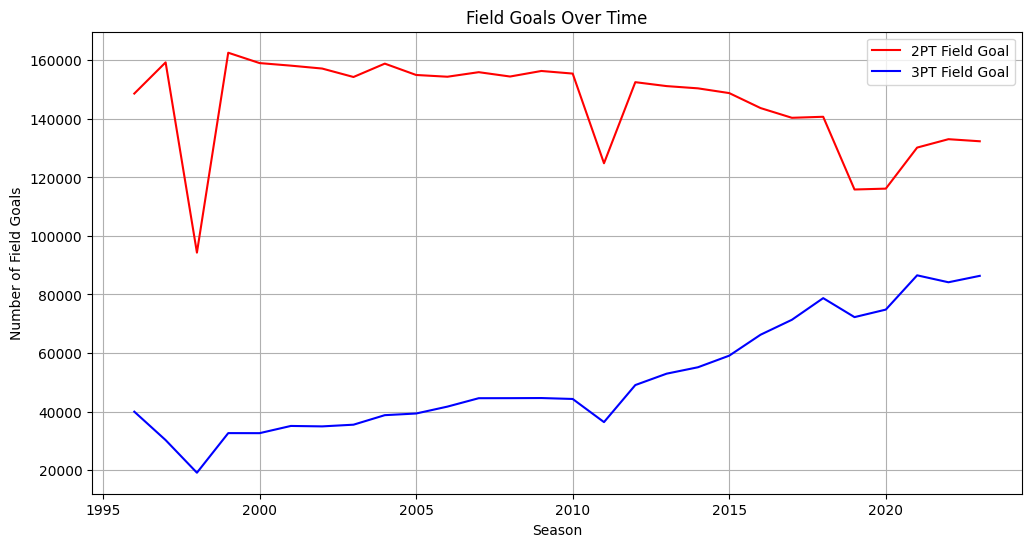

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(three_pt_vol["YEAR"], three_pt_vol["2PT Field Goal"], color='red', label='2PT Field Goal')
plt.plot(three_pt_vol["YEAR"], three_pt_vol["3PT Field Goal"], color='blue', label='3PT Field Goal')

plt.title("Field Goals Over Time")
plt.xlabel("Season")
plt.ylabel("Number of Field Goals")
plt.legend()
plt.grid(True)

# Ratio of 3PT vs 2PT shots

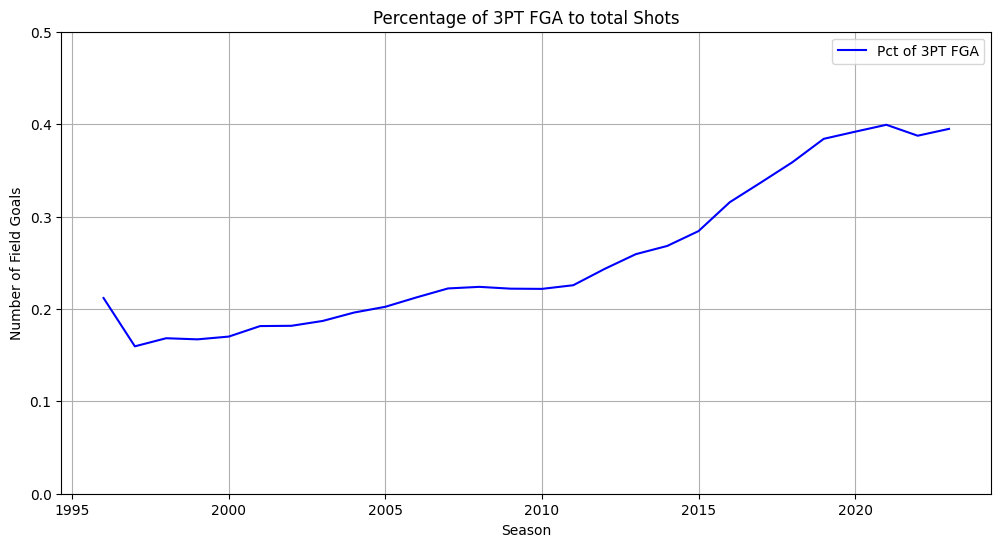

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(three_pt_vol["YEAR"], three_pt_vol["%3PT Total"], color='blue', label='Pct of 3PT FGA')

plt.title("Percentage of 3PT FGA to total Shots")
plt.xlabel("Season")
plt.ylabel("Number of Field Goals")
plt.ylim(0, 0.5)
plt.legend()
plt.grid(True)

# Overall 3PT Percentage

In [26]:
three_pt_vol_3pct = (
    df
    .filter(pl.col("SHOT_TYPE") <= "3PT Field Goal")
    [["YEAR", "EVENT_TYPE"]]
    .group_by(["YEAR", "EVENT_TYPE"])
    .agg(pl.len())
    .rename({"len": "COUNT"})  # Rename 'len' to 'COUNT'
    .drop_nulls()
    .pivot(values="COUNT",
            index="YEAR",
            columns="EVENT_TYPE")
    .with_columns(
        (pl.col("Made Shot") / (pl.col("Made Shot") + pl.col("Missed Shot"))).alias("3PT%")
    )
    .sort(by="YEAR")
)
three_pt_vol_3pct.head()

C:\Users\tonba\AppData\Local\Temp\ipykernel_28000\588342243.py:9: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(values="COUNT",


YEAR,Made Shot,Missed Shot,3PT%
i32,u32,u32,f64
1996,85774,102814,0.454822
1997,85383,104153,0.450484
1998,49549,63828,0.437029
1999,87591,107629,0.448678
2000,84864,106798,0.442779


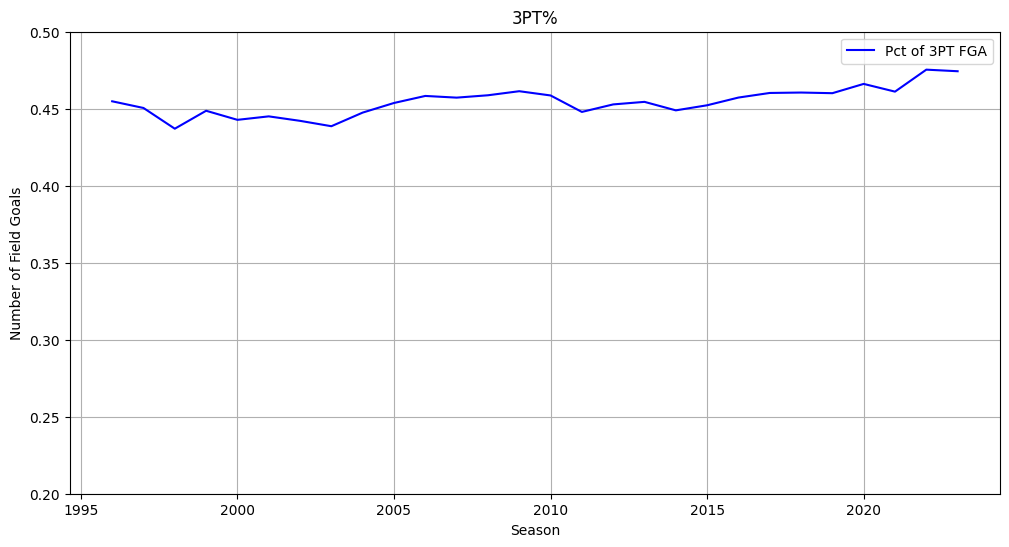

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(three_pt_vol_3pct["YEAR"], three_pt_vol_3pct["3PT%"], color='blue', label='Pct of 3PT FGA')

plt.title("3PT%")
plt.xlabel("Season")
plt.ylabel("Number of Field Goals")
plt.legend()
plt.ylim(0.2, 0.5)
plt.grid(True)

# Histogram of SHOT_DISTANCE

''

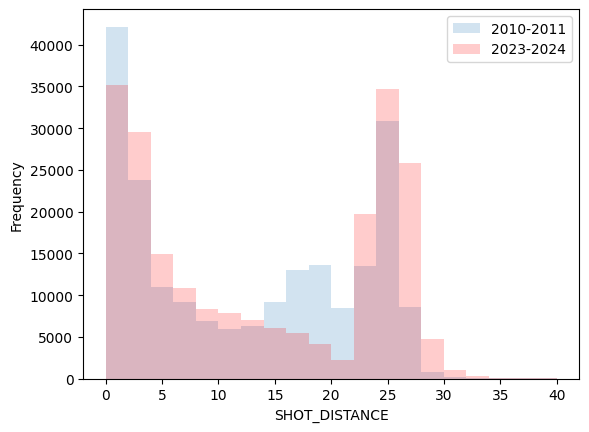

In [35]:
plt.hist(df.filter((pl.col("YEAR") == 2013) & (pl.col("SHOT_DISTANCE") <= 40))["SHOT_DISTANCE"], bins=20, label="2010-2011", alpha=.2)
plt.hist(df.filter((pl.col("YEAR") == 2023) & (pl.col("SHOT_DISTANCE") <= 40))["SHOT_DISTANCE"], bins=20, color="red", label="2023-2024", alpha=.2)
plt.xlabel("SHOT_DISTANCE")
plt.ylabel("Frequency")
plt.legend()
;

# Shot Chart

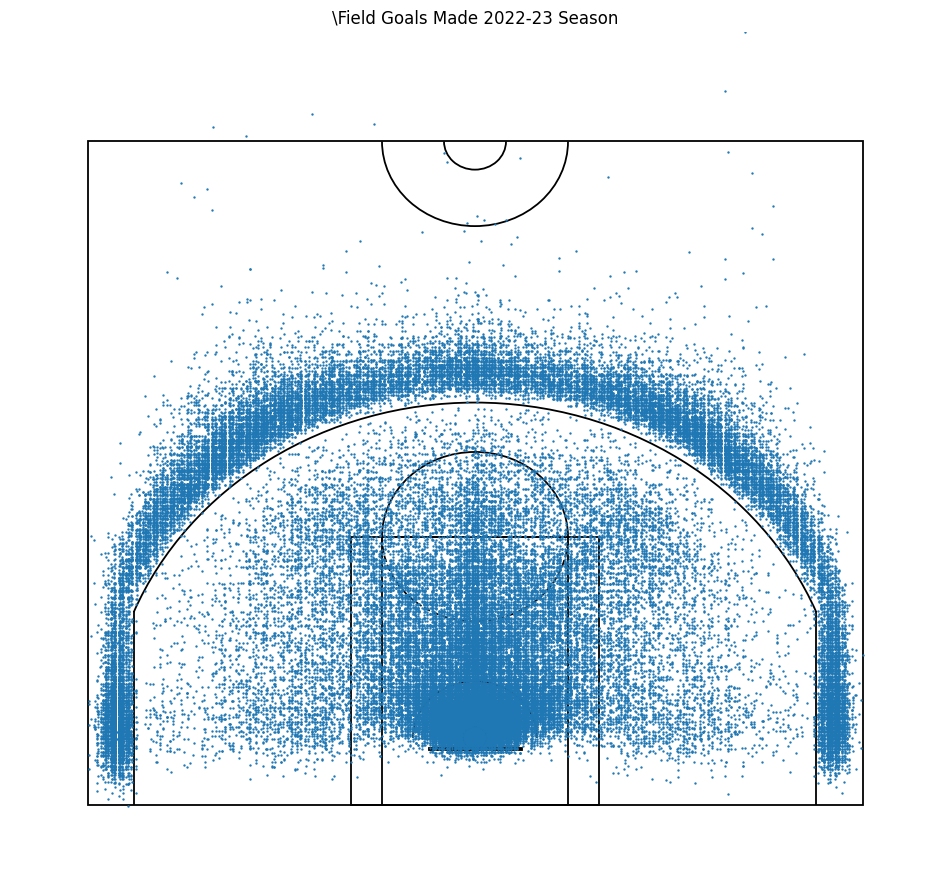

In [7]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=1.3, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 137, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 137, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


def draw_shot_chart(year):
    X = df.filter((pl.col("YEAR") == year) & (pl.col("SHOT_MADE_FLAG") == 1))["LOC_X"]
    Y = df.filter((pl.col("YEAR") == year) & (pl.col("SHOT_MADE_FLAG") == 1))["LOC_Y"]
    fig, ax = plt.subplots(figsize=(12,11), dpi=100)
    draw_court(outer_lines=True)
    ax.scatter(X, Y, s=.5)
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)
    
    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(-300,300)
    ax.set_ylim(-100,500)
    ax.set_title(f"\Field Goals Made {year}-{str(year + 1)[2:]} Season")
    ax.axis('off')
    #fig.tight_layout()
    plt.show();

draw_shot_chart(2022)

# Player Shot Chart

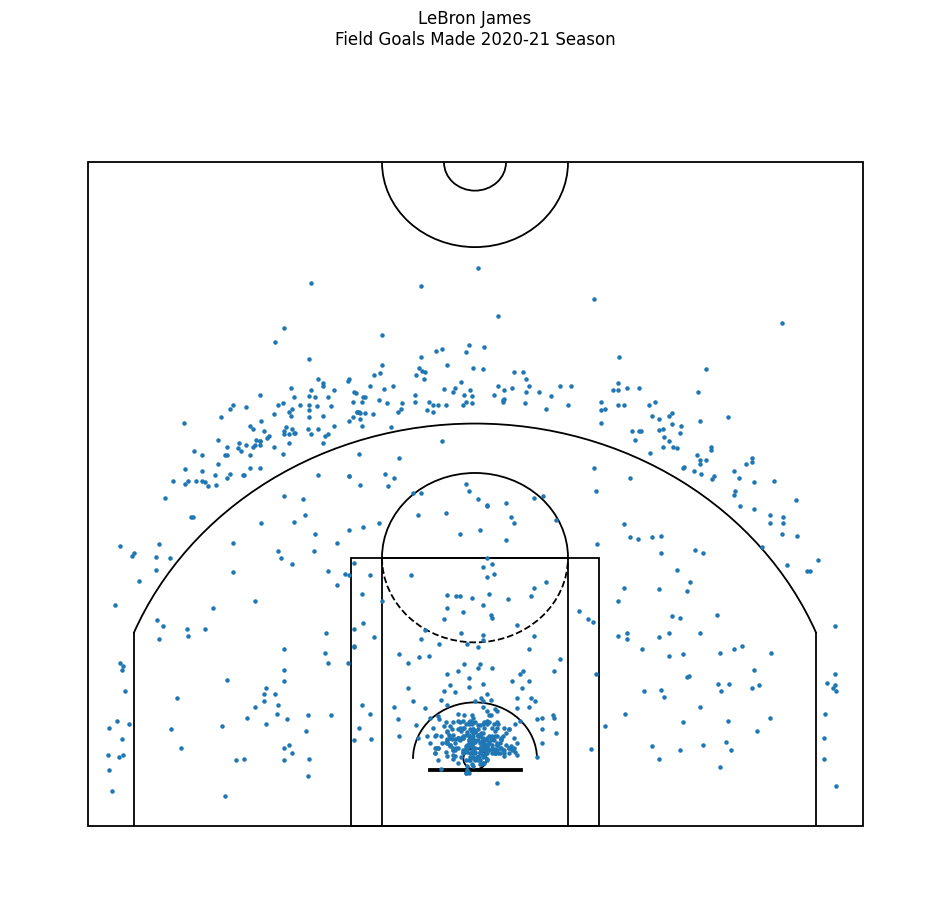

In [8]:
def draw_player_shot_chart(player, year):
    X = df.filter((pl.col("YEAR") == year) & (pl.col("PLAYER_NAME") == player))["LOC_X"]
    Y = df.filter((pl.col("YEAR") == year) & (pl.col("PLAYER_NAME") == player))["LOC_Y"]
    fig, ax = plt.subplots(figsize=(12,11), dpi=100)
    draw_court(outer_lines=True)
    ax.scatter(X, Y, s=5)
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)
    
    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(-300,300)
    ax.set_ylim(-100,500)
    ax.set_title(f"{player}\nField Goals Made {year}-{str(year + 1)[2:]} Season")
    ax.axis('off')
    #fig.tight_layout()
    plt.show();

draw_player_shot_chart("LeBron James", 2020)